In [4]:
import numpy as np
import pandas as pd
import requests

In [14]:
#sql_query = "SELECT TOP 100 sobject_id, star_id, teff,e_teff,logg,e_logg, fe_h, e_fe_h FROM galah_dr3.main_star WHERE sobject_id < 160000000000000 and logg < 2.0" #this was the original ADQL query used by brent.miszalski@mq.edu.au
sql_query = "SELECT sobject_id FROM galah_dr3.main_star"
#Query GALAH DR3 catalogue using DataCentral API
api_url = 'https://datacentral.org.au/api/services/query/'
qdata = {'title' : 'get all sobject_ids of GALAH objects', #give a meaningful name
         'notes' : '', #ok if null
         'sql' : sql_query,
         'run_async' : False,
         'email'  : 'prav.nj@gmail.com'}
post = requests.post(api_url,data=qdata).json()
resp = requests.get(post['url']).json() #Python stores this in memory as a dict object
df = pd.DataFrame(resp['result']['data'],columns=resp['result']['columns']) #write to a df

In [17]:
df #this method restricts the query return to be 1000 records so we can't even get the full list of GALAH objects this way

,sobject_id
0,181222002601125
1,181222002601126
2,181222002601128
3,181222002601129
4,181222002601130
...,...
994,181222004601317
995,181222004601318
996,181222004601319
997,181222004601320


In [14]:
import numpy as np
import astropy.io.fits as pyfits
import matplotlib.pyplot as plt
import glob

In [15]:
def read_spectra(sobject_id):
    fits_files = [[],[],[],[]]
    for each_ccd in [1,2,3,4]:
        fits_files[each_ccd-1] = glob.glob('C:/Users/pravn/Dropbox/masters/python-code/galah-file-read-test/data/GALAH_DR3/spectra/SPECTRA/'+str(sobject_id)+str(each_ccd)+'.fits') #this is reading fits files from file and not downloading directly 

    spectrum = dict()
    for each_ccd in [1,2,3,4]: #GALAH uses indexing from 1 - 4
        if fits_files[each_ccd-1]!=[]: #just using zero indexing here 
            fits = pyfits.open(fits_files[each_ccd-1][0]) 
            
            # Extension 0: Reduced spectrum
            # Extension 1: Relative error spectrum
            # Extension 4: Normalised spectrum, NB: cut for CCD4

            # Extract wavelength grid for the reduced spectrum
            start_wavelength = fits[0].header["CRVAL1"]
            dispersion       = fits[0].header["CDELT1"]
            nr_pixels        = fits[0].header["NAXIS1"]
            reference_pixel  = fits[0].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel = 1
            spectrum['wave_red_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the reduced spectrum 

            # Extract wavelength grid for the normalised spectrum
            start_wavelength = fits[4].header["CRVAL1"]
            dispersion       = fits[4].header["CDELT1"]
            nr_pixels        = fits[4].header["NAXIS1"]
            reference_pixel  = fits[4].header["CRPIX1"]

            if reference_pixel == 0:
                reference_pixel=1
            spectrum['wave_norm_'+str(each_ccd)] = ((np.arange(0,nr_pixels)--reference_pixel+1)*dispersion+start_wavelength) #this is the normalised spectrum 

            # need to confirm how this is calculated 
            spectrum['sob_red_'+str(each_ccd)]  = np.array(fits[0].data)
            spectrum['uob_red_'+str(each_ccd)]  = np.array(fits[0].data * fits[1].data)

            # need to confirm how this is calculated 
            spectrum['sob_norm_'+str(each_ccd)] = np.array(fits[4].data)
            if each_ccd != 4:
                spectrum['uob_norm_'+str(each_ccd)] = np.array(fits[4].data * fits[1].data)
            else:
                # for normalised error of CCD4, only used appropriate parts of error spectrum
                spectrum['uob_norm_4'] = np.array(fits[4].data * (fits[1].data)[-len(spectrum['sob_norm_4']):])

            fits.close()
        else:
            spectrum['wave_red_'+str(each_ccd)] = []
            spectrum['wave_norm_'+str(each_ccd)] = []
            spectrum['sob_red_'+str(each_ccd)] = []
            spectrum['sob_norm_'+str(each_ccd)] = []
            spectrum['uob_red_'+str(each_ccd)] = []
            spectrum['uob_norm_'+str(each_ccd)] = []
    
    spectrum['wave_red'] = np.concatenate(([spectrum['wave_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['wave_norm'] = np.concatenate(([spectrum['wave_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_red'] = np.concatenate(([spectrum['sob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['sob_norm'] = np.concatenate(([spectrum['sob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_red'] = np.concatenate(([spectrum['uob_red_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))
    spectrum['uob_norm'] = np.concatenate(([spectrum['uob_norm_'+str(each_ccd)] for each_ccd in [1,2,3,4]]))

    return spectrum 

In [16]:
def plot_spectra(sobject_id, normalised=True):
    """
    Plot the spectra in a 4x1 panel figure
    """
    f, ccds = plt.subplots(4,1,figsize=(11.69, 8.27))
    kwargs_sob = dict(c = 'k', lw=0.5, label='Flux', rasterized=True)
    kwargs_error_spectrum = dict(color = 'grey', label='Flux error', rasterized=True)

    for each_ccd in [1,2,3,4]:
        ax=ccds[each_ccd-1]
        
        if normalised:
            red_norm = 'norm'
        else:
            red_norm = 'red'
            
        # Plot the uncertainty as grey background
        ax.fill_between(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] - spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)] + spectrum['uob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_error_spectrum
            )
        
        # Overplot observed spectrum a bit thicker
        ax.plot(
            spectrum['wave_'+red_norm+'_'+str(each_ccd)],
            spectrum['sob_'+red_norm+'_'+str(each_ccd)],
            **kwargs_sob
            )
        
        if normalised:
            ax.set_ylabel('Flux [norm.]')
            ax.set_ylim(-0.1,1.3)
        else:
            ax.set_ylabel('Counts')
            ax.set_ylim(0,1.1*np.percentile(spectrum['sob_red_'+str(each_ccd)],q=95))
        if each_ccd == 1:
            ax.set_title(str(sobject_id))
            ax.set_xlim(4710,4905)
        if each_ccd == 2:
            ax.set_xlim(5645,5877.5)
        if each_ccd == 3:
            ax.set_xlim(6472.5,6740)
        if each_ccd == 4:
            ax.set_xlim(7580,7890)
            ax.set_xlabel('Wavelength [Å]')
        if each_ccd == 4:
            ax.legend(loc='lower left')             
    plt.tight_layout()
    
    plt.show()
    plt.close()
    
    return f

In [17]:
spectrum = read_spectra(170418003701205)

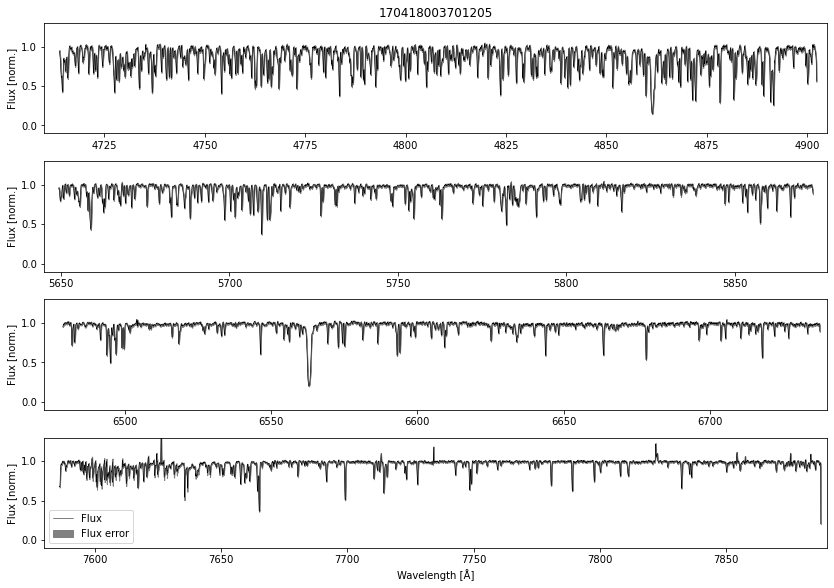

In [18]:
f = plot_spectra(170418003701205, normalised=normalised)